1. Lookback window 사이즈를 다르게 주자

2. 리벨런싱 주기를 다르게

3. max_ratio를 다르게

4. Shrinkage Method를 다르게

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import ray

from optimize_multi.object_function import * 
from optimize_multi.optimizer_v2 import run_optimizer
from optimize_multi.backtest import simulate_strategy

from ryu_tool.mytool import draw_return_result, print_statistics, run_alpha_regression

2023-05-22 17:55:37,840	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
# 필요한 데이터 불러오기
rtn = pd.read_pickle("Data/ETF_final.pickle")
rtn

,BIL,DBA,IJS,QQQ,VWO,TLT,SHY,GLD,GSG,VNQ
2007-06-04,0.000218,-0.006063,0.001453,0.002964,-0.003135,0.004557,0.000376,0.001505,0.012750,0.004048
2007-06-05,0.000000,0.003050,-0.008464,0.000000,-0.005392,-0.006281,-0.000878,-0.002555,-0.002209,-0.015873
2007-06-06,0.000436,-0.007602,-0.011951,-0.010553,-0.016716,-0.000468,0.001255,0.000603,0.000548,-0.006784
2007-06-07,-0.000218,0.017235,-0.018267,-0.015572,-0.017459,-0.017916,-0.001128,-0.017317,0.000476,-0.031447
2007-06-08,0.000218,-0.004895,0.009555,0.012351,0.023381,-0.000835,0.000376,-0.015936,-0.023781,0.011976
...,...,...,...,...,...,...,...,...,...,...
2023-04-25,-0.000109,-0.003324,-0.027506,-0.018864,-0.017043,0.014704,0.003901,0.005086,-0.018155,-0.009871
2023-04-26,0.000218,0.001429,-0.008832,0.006065,0.006884,-0.010658,-0.001214,-0.005437,-0.020490,-0.009600
2023-04-27,0.000327,-0.001903,0.017144,0.027191,0.012915,-0.009923,-0.001945,0.000054,0.001531,0.022617
2023-04-28,0.000000,-0.001430,0.012974,0.006899,0.006000,0.016131,0.001096,0.000271,0.014264,0.012274


In [3]:
# Ray를 사용하기 위해 Ray데이터 생성
rtn_ray = ray.put(rtn)

In [4]:
# S&P500 마켓 데이터 (결과 비교를 위해)
spx = pd.read_csv("Data/spx_hist.csv", 
                  index_col=0,
                  parse_dates=True).pct_change(fill_method=None)

# Investing.com에서 받아와서 그런지 Timestamp에 문제가 있다
problem = [pd.Timestamp('2021-07-03 00:00:00'),
           pd.Timestamp('2021-07-04 00:00:00'),
           pd.Timestamp('2021-07-05 00:00:00'),
           pd.Timestamp('2021-08-07 00:00:00'),
           pd.Timestamp('2021-08-08 00:00:00')]

spx = spx.drop(problem)

In [21]:
look_back_list = [60, 120, 180, 240, 300, 365, 400, 450]
look_back_list2 = [90, 110, 130, 150, 170]
args_lst = [0.1, 1, 3, 5, 10, 20]

In [22]:
for_loop = look_back_list

In [23]:
# ETF Optimizing
futures = [run_optimizer.remote(obj_function=obj_sharpe, 
                                rtn_df=rtn_ray,
                                spx_mask="None",
                                start_year="2008",
                                end_year="2023",
                                rebalancing="Q",
                                look_back_size=arg,
                                max_ratio=1,
                                min_ratio=0.05,
                                shrinkage_method="None",
                                arg=0.5)  for arg in for_loop]
result = ray.get(futures)

 42%|████▏     | 25/60 [00:00<00:00, 80.45it/s]


In [25]:
result_dict = {}
weight_dict = {}

for i, arg in enumerate(for_loop):
    rt, weig = simulate_strategy(result[i], rtn, fee_rate=0.0015)
    result_dict[f"Minimun Variance Portfolio / Look Back {arg} days"] = rt
    weight_dict[str(arg)] = weig

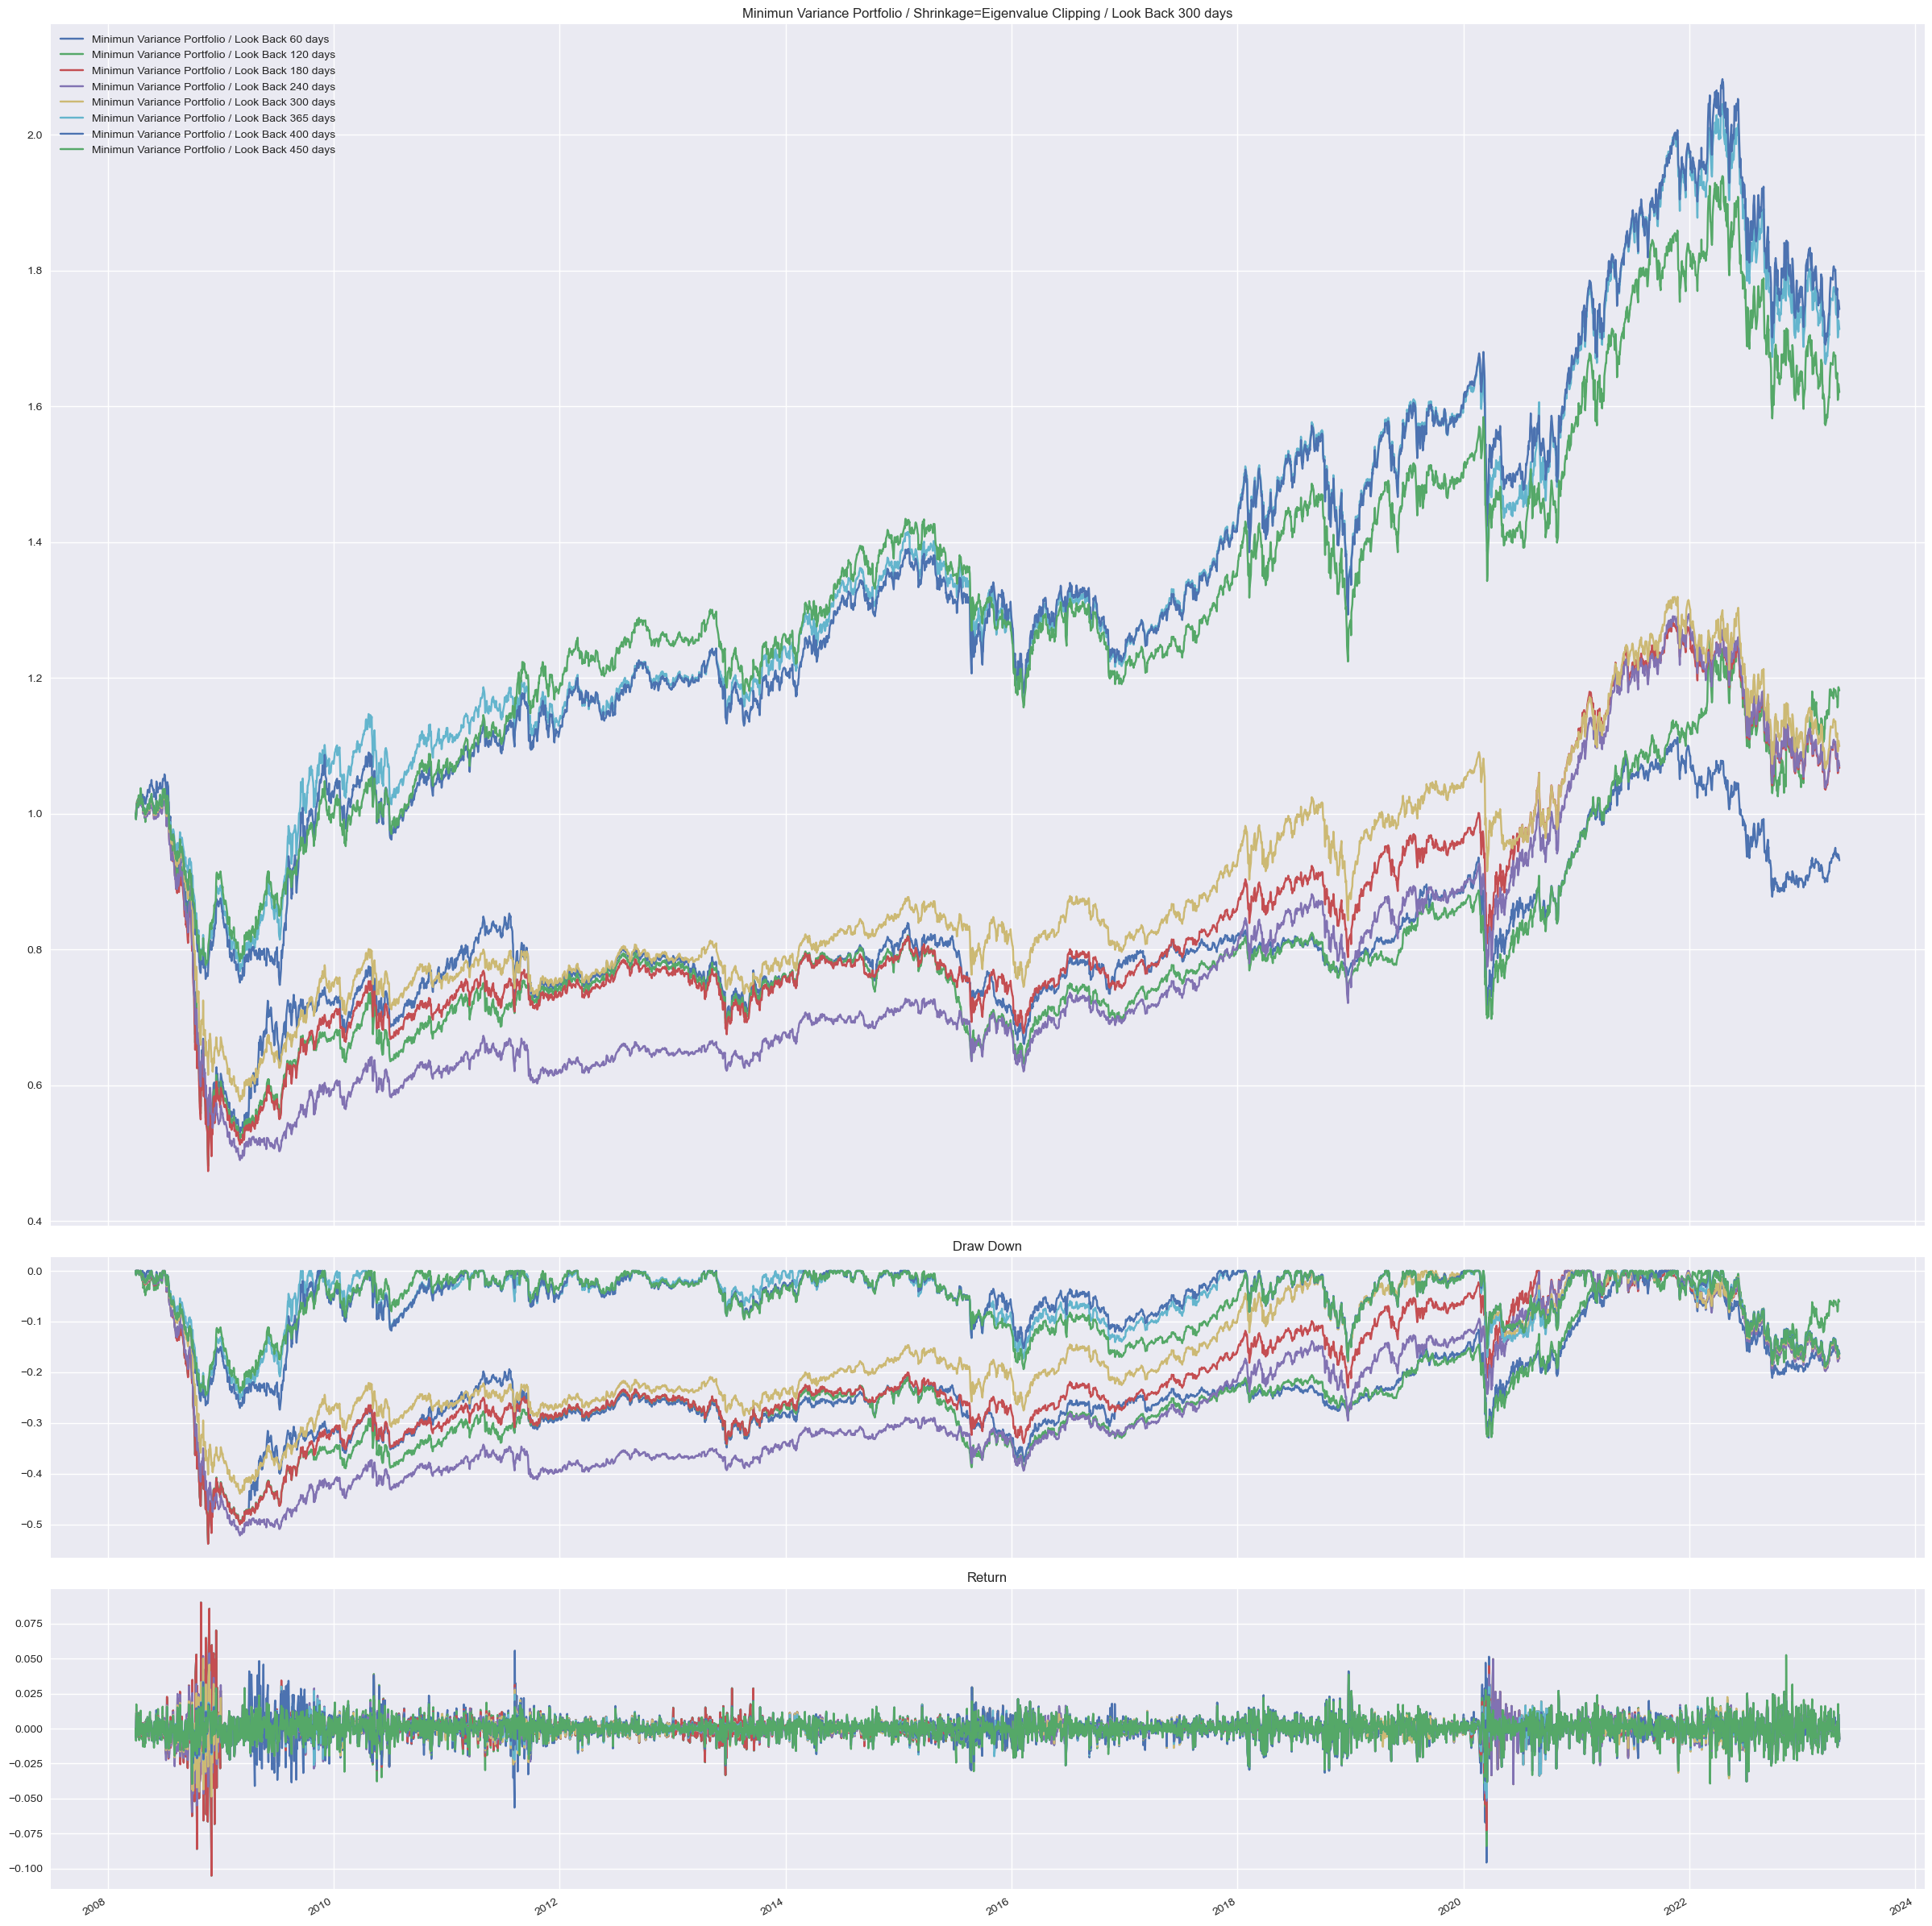

In [26]:
draw_return_result(result_dict,
                   one_plot=True,
                   title="Minimun Variance Portfolio / Shrinkage=Eigenvalue Clipping / Look Back 300 days")

In [27]:
stats = print_statistics(result_dict)
stats.columns = [f"{day}" for day in for_loop]
stats

,60,120,180,240,300,365,400,450
CAGR,-0.004400,0.011600,0.004600,0.004900,0.006600,0.036500,0.037700,0.032700
Mean,0.010700,0.033040,0.023320,0.019220,0.020390,0.062660,0.064370,0.055820
STD,0.186927,0.184071,0.184358,0.159126,0.150089,0.147522,0.147998,0.137062
MDD,0.537000,0.537000,0.538000,0.521000,0.439000,0.253000,0.274000,0.245000
Sharpe,0.057242,0.179496,0.126493,0.120785,0.135852,0.424749,0.434937,0.407260


In [ ]:
weight_dict.keys()

In [ ]:
weight_dict["240"]

In [ ]:
weight_dict["300"].plot(figsize=(24,12),
                        legend=False)
plt.title("Minimum Variance / Q / max_ratio=1 / Look Back Window = 300 days")

In [ ]:
portfolio = result_dict["Eigenvalue Clipping / Alpha=5 / Look Back 150 days"]
spx_sample = spx.loc[portfolio.index[0]:]["Price"] # Series로 변경

draw_return_result({"Eigenvalue Clipping / Alpha=5 / Look Back 150 days":portfolio,
                    "S&P500": spx_sample},
                   one_plot=True)

In [ ]:
st = print_statistics({"Eigenvalue Clipping / Alpha=5 / Look Back 150 days":portfolio,
                       "S&P500": spx_sample})
st.columns = ["Eigenvalue Clipping","S&P500"]
st

In [ ]:
run_alpha_regression({"Eigenvalue Clipping":portfolio.iloc[1:]},
                     mkt_rtn=spx_sample)